In [1]:
import healpy as hp 
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
import pickle as pl

In [2]:
%load_ext autoreload
%autoreload 2
from taunet.simulation import CMBmap, FGMap, SkySimulation,CMBspectra
from taunet.ncm import NoiseModel,NoiseModelGaussian

In [3]:
ncm = NoiseModel()

In [4]:
mask = ncm.polmask()

In [5]:
main_dir = '/marconi/home/userexternal/aidicher/storage/TAUNET'
clean_dir = os.path.join(main_dir,'CLEAN')

In [6]:
cmb_dir = os.path.join(main_dir,'CMB')

In [8]:
Earr = []
for i in tqdm(range(10)):
    CMB_QU = pl.load(open(os.path.join(cmb_dir,f'QU_b1_{i:04d}.pkl'),'rb'))
    cmb_alm = hp.map2alm_spin(CMB_QU,spin=2)
    ee = hp.alm2cl(cmb_alm[0])
    Earr.append(ee)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 38.73it/s]


In [9]:
Earr = np.array(Earr)

In [20]:
cmb_alm = hp.map2alm_spin(CMB_QU,spin=2)

In [2]:
import healpy as hp

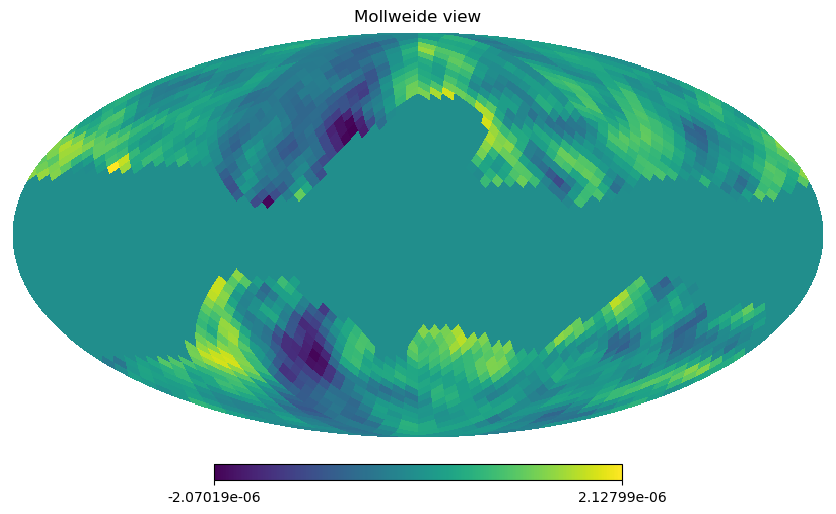

In [6]:

hp.mollview(hp.read_map('/marconi/home/userexternal/aidicher/storage/TAUNET/SIMULATIONS_s0d0/sky_100_3.fits',(0,1,2))[1])

In [5]:
hp.read_map('/marconi/home/userexternal/aidicher/storage/TAUNET/SIMULATIONS_s0d0/sky_100_1.fits')

array([-0.,  0., -0., ...,  0., -0.,  0.])

In [10]:
nsim = 10
tau = 0.06
fg_model = ['s0','d0']

In [11]:
spectra = CMBspectra(tau=tau)

In [13]:
clean0 = hp.read_map(os.path.join(clean_dir,'cleaned_100_0.fits'),(0,1,2))

NameError: name 'clean_dir' is not defined

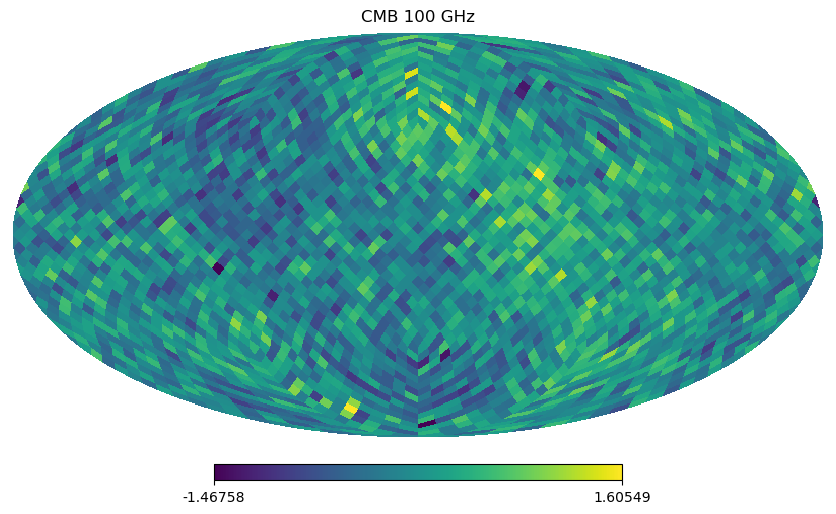

In [14]:
hp.mollview(CMB_QU[1],title='CMB 100 GHz')

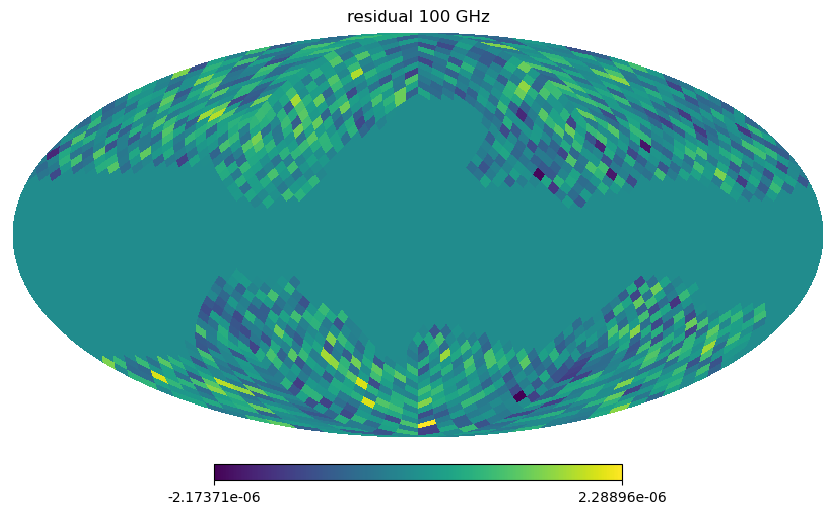

In [19]:
hp.mollview(clean0[1]-CMB_QU[1]*1e-6*mask,title='residual 100 GHz')

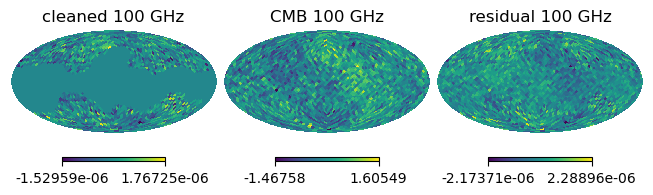

In [13]:
hp.mollview(clean0[1],title='cleaned 100 GHz',sub=(1,3,1))
hp.mollview(CMB_QU[1],title='CMB 100 GHz',sub=(1,3,2))
hp.mollview(clean0[1]-CMB_QU[1]*1e-6,title='residual 100 GHz',sub=(1,3,3))


In [12]:
def get_cl(f,nsim,f1=None):
    cl = []
    for i in tqdm(range(nsim)):
        fname = os.path.join(clean_dir,f'cleaned_{f}_{i}.fits')
        Q,U = hp.read_map(fname,field=(1,2))
        _,E,_ = hp.map2alm([Q*0,Q,U])
        if f1 is not None:
            fname = os.path.join(clean_dir,f'cleaned_{f1}_{i}.fits')
            Q1,U1 = hp.read_map(fname,field=(1,2))
            _,E1,_ = hp.map2alm([Q1*0,Q1,U1])
            cl.append(hp.alm2cl(E,E1))
        else:
            cl.append(hp.alm2cl(E))
    return np.array(cl)


In [17]:
cl_100 = get_cl('100',nsim)

100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


In [18]:
cl_143 = get_cl('143',nsim)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:45<00:00,  4.60s/it]


In [13]:
cl_100_143 = get_cl('100',nsim,'143')

100%|██████████| 10/10 [00:00<00:00, 11.62it/s]


In [18]:
l = np.arange(len(cl_100_143[0]))

In [14]:
ncm = NoiseModel()

In [15]:
nl_100,nl_143 = [],[]
for i in tqdm(range(nsim)):
    nl_100.append(hp.alm2cl(ncm.Emode(100)))
    nl_143.append(hp.alm2cl(ncm.Emode(143)))
nl_100 = np.array(nl_100).mean(axis=0)
nl_143 = np.array(nl_143).mean(axis=0)

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


In [11]:
noise_levels = {
    '100': 55,
    '143': 60,
}
nl_100, nl_143 = [],[]
for i in tqdm(range(nsim)):
    nl_100.append(hp.alm2cl(NoiseModelGaussian(16,noise_levels['100']).Emode()))
    nl_143.append(hp.alm2cl(NoiseModelGaussian(16,noise_levels['143']).Emode()))
nl_100 = np.array(nl_100).mean(axis=0)
nl_143 = np.array(nl_143).mean(axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


(1.8, 40)

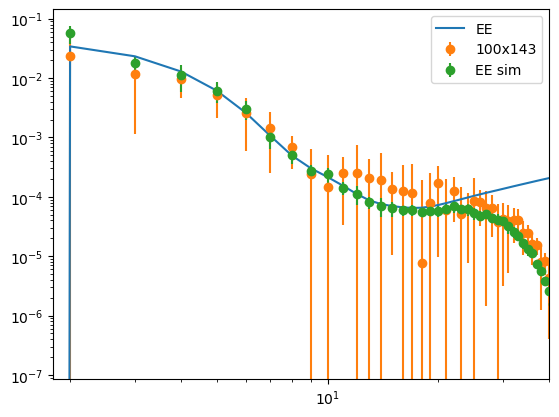

In [24]:
#plt.errorbar(l,(cl_100.mean(axis=0)*1e12 - nl_100)/0.54,yerr=cl_100.std(axis=0)*1e12/0.54,fmt='o',label='100')
#plt.errorbar(l,(cl_143.mean(axis=0)*1e12 - nl_143)/0.54,yerr=cl_143.std(axis=0)*1e12/0.54,fmt='o',label='143')
plt.loglog(l,spectra.EE[:48],label='EE')
plt.errorbar(l,cl_100_143.mean(axis=0)*1e12/0.54,yerr=cl_100_143.std(axis=0)*1e12/0.54,fmt='o',label='100x143')
#plt.loglog(hp.alm2cl(cmb_alm[0]),label='EE')

plt.errorbar(l,Earr.mean(axis=0),yerr=Earr.std(axis=0),fmt='o',label='EE sim')
plt.legend()
plt.xlim(1.8,40)